In [1]:
import os
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

import random
import librosa
import soundfile as sf
from tqdm import tqdm

from os import walk
import copy
import pickle
import pandas as pd

#import model:
import import_ipynb
import model

# check if files can be opened
print(os.listdir("./"))

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only.")

importing Jupyter notebook from model.ipynb
['.git', '.gitignore', '.ipynb_checkpoints', 'epoch3.pth', 'model.ipynb', 'preprocess.ipynb', 'README.md', 'test1.wav', 'test2.wav', 'train.ipynb']
PyTorch Version:  2.1.0
Torchvision Version:  0.16.0
Using the GPU!


In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []
        
        self.labels_to_int = {}
        labels = sorted(os.listdir(root_dir))
        for i in range(len(labels)):
            self.labels_to_int[labels[i]] = i

        # Iterate through each class folder
        for class_folder in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_folder)
            
            # Check if it's a directory
            if os.path.isdir(class_path):
                # Iterate through CSV files in the class folder
                for file_name in os.listdir(class_path):
                    if file_name.endswith('.csv'):
                        file_path = os.path.join(class_path, file_name)
                        self.file_list.append((file_path, class_folder))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        data = np.genfromtxt(file_path, delimiter=',')
        
        #random crop
        if(data.shape[1] > 100):
            rng = random.randrange(0, data.shape[1]-100)
            data = torch.tensor([data[:, rng:rng+100]], dtype=torch.float32)
        else:
            data = torch.tensor([data], dtype=torch.float32)
        
        label = self.labels_to_int[label]
        sample = {'data': data, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample


In [3]:
net = model.Net()
net.to(device)
summary(net, input_size = (64, 1, 128, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 7]                   --
├─Sequential: 1-1                        [64, 64, 128, 100]        --
│    └─Conv2d: 2-1                       [64, 64, 128, 100]        640
│    └─BatchNorm2d: 2-2                  [64, 64, 128, 100]        128
│    └─ReLU: 2-3                         [64, 64, 128, 100]        --
├─Sequential: 1-2                        [64, 64, 128, 100]        --
│    └─Conv2d: 2-4                       [64, 64, 128, 100]        36,928
│    └─BatchNorm2d: 2-5                  [64, 64, 128, 100]        128
│    └─ReLU: 2-6                         [64, 64, 128, 100]        --
├─MaxPool2d: 1-3                         [64, 64, 64, 50]          --
├─Sequential: 1-4                        [64, 128, 64, 50]         --
│    └─Conv2d: 2-7                       [64, 128, 64, 50]         73,856
│    └─BatchNorm2d: 2-8                  [64, 128, 64, 50]         256
│  

In [4]:
num_epoch = 3
b_size = 32

root_dir = 'C:\GenshinVoice\Melspec_data'
custom_dataset = CustomDataset(root_dir)
dataloader = DataLoader(custom_dataset, batch_size=b_size, shuffle=True)

total_step = len(dataloader)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
for epoch in tqdm(range(1, num_epoch+1)):  # loop over the dataset multiple times
    running_loss = 0.0
    running_correct = 0
    print('------ Starting Epoch [{}/{}] ------'.format(epoch, num_epoch))
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data['data'], data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)

        # back prop
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item()*inputs.size(0)
        curr_correct = torch.sum(preds == labels)
        running_correct += curr_correct
        if i % 50 == 1:
            print('Epoch [{}/{}], Step [{}/{}], Running Loss: {:.4f}, running Correct: [{}/{}]'
            .format(epoch, num_epoch, i+1, total_step, running_loss, running_correct, (i+1)*b_size))

print('Finished Training')

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Joshua Ning\AppData\Local\Temp\ipykernel_3956\4267167693.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  data = torch.tensor([data[:, rng:rng+100]], dtype=torch.float32)


------ Starting Epoch [1/3] ------
Epoch [1/3], Step [2/343], Running Loss: 118.6561, running Correct: [24/64]
Epoch [1/3], Step [52/343], Running Loss: 1595.3529, running Correct: [1088/1664]
Epoch [1/3], Step [102/343], Running Loss: 2614.0189, running Correct: [2284/3264]
Epoch [1/3], Step [152/343], Running Loss: 3438.5624, running Correct: [3528/4864]
Epoch [1/3], Step [202/343], Running Loss: 4126.8821, running Correct: [4847/6464]
Epoch [1/3], Step [252/343], Running Loss: 4696.3469, running Correct: [6192/8064]
Epoch [1/3], Step [302/343], Running Loss: 5185.8447, running Correct: [7569/9664]


 33%|███▎      | 1/3 [02:42<05:25, 162.62s/it]

------ Starting Epoch [2/3] ------
Epoch [2/3], Step [2/343], Running Loss: 22.1838, running Correct: [55/64]
Epoch [2/3], Step [52/343], Running Loss: 400.0369, running Correct: [1493/1664]
Epoch [2/3], Step [102/343], Running Loss: 751.3124, running Correct: [2946/3264]
Epoch [2/3], Step [152/343], Running Loss: 1005.6381, running Correct: [4459/4864]
Epoch [2/3], Step [202/343], Running Loss: 1241.8065, running Correct: [5972/6464]
Epoch [2/3], Step [252/343], Running Loss: 1413.3070, running Correct: [7510/8064]
Epoch [2/3], Step [302/343], Running Loss: 1534.4872, running Correct: [9069/9664]


 67%|██████▋   | 2/3 [05:10<02:33, 153.79s/it]

------ Starting Epoch [3/3] ------
Epoch [3/3], Step [2/343], Running Loss: 3.0454, running Correct: [63/64]
Epoch [3/3], Step [52/343], Running Loss: 80.4622, running Correct: [1633/1664]
Epoch [3/3], Step [102/343], Running Loss: 165.1648, running Correct: [3201/3264]
Epoch [3/3], Step [152/343], Running Loss: 242.3073, running Correct: [4779/4864]
Epoch [3/3], Step [202/343], Running Loss: 311.5435, running Correct: [6355/6464]
Epoch [3/3], Step [252/343], Running Loss: 400.0173, running Correct: [7930/8064]
Epoch [3/3], Step [302/343], Running Loss: 482.1870, running Correct: [9507/9664]


100%|██████████| 3/3 [07:41<00:00, 153.85s/it]

Finished Training


In [6]:
#save model
PATH = 'epoch3.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
#load model
load_path = 'epoch3.pth'
check_point = {'model_state_dict':torch.load(load_path, map_location=torch.device(device))}
net.load_state_dict(check_point['model_state_dict'])

## Test Set 
This test set is with the same data distribution as the training set

In [7]:
b_size = 32
root_dir = 'C:\GenshinVoice\Melspec_data_test'
test_dataset = CustomDataset(root_dir)
testloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

In [8]:
correct = 0
total = 0
all_preds = np.empty((0,32), int)
all_labels = np.empty((0,32), int)

with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        inputs, labels = data['data'], data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        preds = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += torch.sum(preds == labels)

        all_preds = np.append(all_preds, preds.cpu().numpy())
        all_labels = np.append(all_labels, labels.cpu().numpy())

print('percent correct: ', 100.0*correct/total)

147it [01:02,  2.34it/s]

percent correct:  tensor(99.0215, device='cuda:0')


C:\Users\Joshua Ning\AppData\Local\Temp\ipykernel_3956\3598236449.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(axis_label)
C:\Users\Joshua Ning\AppData\Local\Temp\ipykernel_3956\3598236449.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(axis_label)


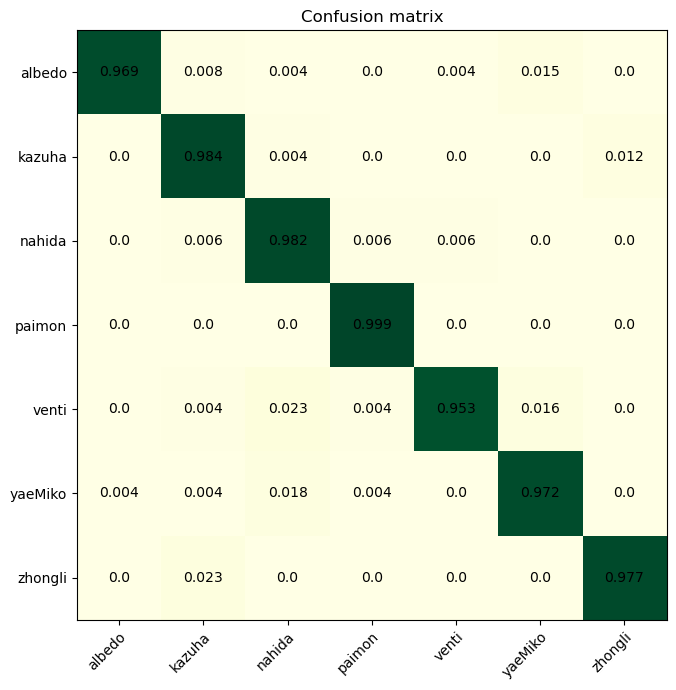

In [9]:
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib.pyplot as plt

axis_label =   ["albedo",
                "kazuha",
                "nahida",
                "paimon",
                "venti",
                "yaeMiko",
                "zhongli"]

confmat = MulticlassConfusionMatrix(task="multiclass", num_classes=7, normalize='true')
confmat = confmat(torch.from_numpy(all_preds), torch.from_numpy(all_labels))
confmat.numpy()
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.imshow(confmat, cmap="YlGn")
ax.set_xticklabels(axis_label)
ax.set_yticklabels(axis_label)
ax.set_xticks(np.arange(len(axis_label)))
ax.set_yticks(np.arange(len(axis_label)))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(axis_label)):
    for j in range(len(axis_label)):
        text = ax.text(j, i, np.around(confmat[i, j].numpy(), decimals=3),
                       ha="center", va="center", color="#000000")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

## Verify Class Imbalance
Create another test set with the amount of test samples limited to 250 each

In [10]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []
        
        self.labels_to_int = {}
        labels = sorted(os.listdir(root_dir))
        for i in range(len(labels)):
            self.labels_to_int[labels[i]] = i

        # Iterate through each class folder
        for class_folder in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_folder)
            
            # Check if it's a directory
            if os.path.isdir(class_path):
                # Iterate through CSV files in the class folder
                for num_files, file_name in enumerate(os.listdir(class_path)):
                    if file_name.endswith('.csv'):
                        file_path = os.path.join(class_path, file_name)
                        self.file_list.append((file_path, class_folder))
                    if num_files == 250:
                        break

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        data = np.genfromtxt(file_path, delimiter=',')
        
        #random crop
        if(data.shape[1] > 100):
            rng = random.randrange(0, data.shape[1]-100)
            data = torch.tensor([data[:, rng:rng+100]], dtype=torch.float32)
        else:
            data = torch.tensor([data], dtype=torch.float32)
        
        label = self.labels_to_int[label]
        sample = {'data': data, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [11]:
b_size = 32
root_dir = 'C:\GenshinVoice\Melspec_data_test'
test_dataset = TestDataset(root_dir)
testloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

In [12]:
correct = 0
total = 0
all_preds = np.empty((0,32), int)
all_labels = np.empty((0,32), int)

with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        inputs, labels = data['data'], data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        preds = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += torch.sum(preds == labels)

        all_preds = np.append(all_preds, preds.cpu().numpy())
        all_labels = np.append(all_labels, labels.cpu().numpy())

55it [00:27,  2.01it/s]


C:\Users\Joshua Ning\AppData\Local\Temp\ipykernel_3956\3598236449.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(axis_label)
C:\Users\Joshua Ning\AppData\Local\Temp\ipykernel_3956\3598236449.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(axis_label)


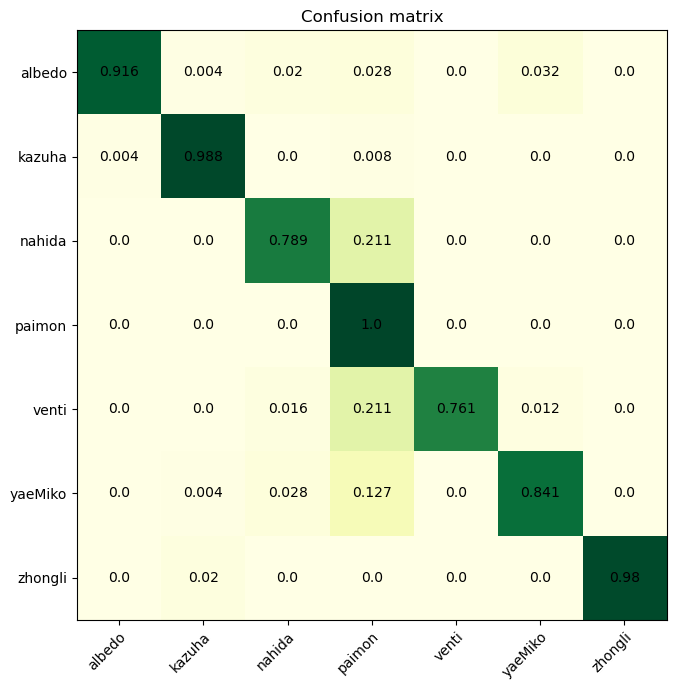

In [13]:
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib.pyplot as plt

axis_label =   ["albedo",
                "kazuha",
                "nahida",
                "paimon",
                "venti",
                "yaeMiko",
                "zhongli"]

confmat = MulticlassConfusionMatrix(task="multiclass", num_classes=7, normalize='true')
confmat = confmat(torch.from_numpy(all_preds), torch.from_numpy(all_labels))
confmat.numpy()
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.imshow(confmat, cmap="YlGn")
ax.set_xticklabels(axis_label)
ax.set_yticklabels(axis_label)
ax.set_xticks(np.arange(len(axis_label)))
ax.set_yticks(np.arange(len(axis_label)))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(axis_label)):
    for j in range(len(axis_label)):
        text = ax.text(j, i, np.around(confmat[i, j].numpy(), decimals=3),
                       ha="center", va="center", color="#000000")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()

## Class Imbalance observed
The model have a tendency to guess paimon, the class with the most training data. We want to penalize the class with more training samples

Here we train again with penalty applied

In [26]:
num_epoch = 3
b_size = 32

root_dir = 'C:\GenshinVoice\Melspec_data'
custom_dataset = CustomDataset(root_dir)
dataloader = DataLoader(custom_dataset, batch_size=b_size, shuffle=True)

total_step = len(dataloader)
num_train_per_class = np.array([606,581,781,7108,597,664,620], dtype = 'f4')
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(num_train_per_class).to(device))
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:
for epoch in tqdm(range(1, num_epoch+1)):  # loop over the dataset multiple times
    running_loss = 0.0
    running_correct = 0
    print('------ Starting Epoch [{}/{}] ------'.format(epoch, num_epoch))
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data['data'], data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)

        # back prop
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item()*inputs.size(0)
        curr_correct = torch.sum(preds == labels)
        running_correct += curr_correct
        if i % 50 == 1:
            print('Epoch [{}/{}], Step [{}/{}], Running Loss: {:.4f}, running Correct: [{}/{}]'
            .format(epoch, num_epoch, i+1, total_step, running_loss, running_correct, (i+1)*b_size))

print('Finished Training')

  0%|          | 0/3 [00:00<?, ?it/s]

------ Starting Epoch [1/3] ------
Epoch [1/3], Step [2/343], Running Loss: 0.0325, running Correct: [64/64]
Epoch [1/3], Step [52/343], Running Loss: 5.5237, running Correct: [1652/1664]
Epoch [1/3], Step [102/343], Running Loss: 11.3016, running Correct: [3240/3264]
Epoch [1/3], Step [152/343], Running Loss: 22.2386, running Correct: [4827/4864]
Epoch [1/3], Step [202/343], Running Loss: 27.7170, running Correct: [6413/6464]
Epoch [1/3], Step [252/343], Running Loss: 32.5734, running Correct: [8005/8064]
Epoch [1/3], Step [302/343], Running Loss: 38.7804, running Correct: [9597/9664]


 33%|███▎      | 1/3 [02:35<05:10, 155.47s/it]

------ Starting Epoch [2/3] ------
Epoch [2/3], Step [2/343], Running Loss: 0.1263, running Correct: [64/64]
Epoch [2/3], Step [52/343], Running Loss: 5.1458, running Correct: [1655/1664]
Epoch [2/3], Step [102/343], Running Loss: 10.2223, running Correct: [3249/3264]
Epoch [2/3], Step [152/343], Running Loss: 15.3286, running Correct: [4841/4864]
Epoch [2/3], Step [202/343], Running Loss: 20.4338, running Correct: [6431/6464]
Epoch [2/3], Step [252/343], Running Loss: 24.3999, running Correct: [8025/8064]
Epoch [2/3], Step [302/343], Running Loss: 26.7609, running Correct: [9622/9664]


 67%|██████▋   | 2/3 [05:12<02:36, 156.57s/it]

------ Starting Epoch [3/3] ------
Epoch [3/3], Step [2/343], Running Loss: 0.0581, running Correct: [64/64]
Epoch [3/3], Step [52/343], Running Loss: 2.5576, running Correct: [1661/1664]
Epoch [3/3], Step [102/343], Running Loss: 6.6211, running Correct: [3256/3264]
Epoch [3/3], Step [152/343], Running Loss: 10.1553, running Correct: [4852/4864]
Epoch [3/3], Step [202/343], Running Loss: 12.6156, running Correct: [6447/6464]
Epoch [3/3], Step [252/343], Running Loss: 15.4932, running Correct: [8042/8064]
Epoch [3/3], Step [302/343], Running Loss: 18.4404, running Correct: [9636/9664]


100%|██████████| 3/3 [07:50<00:00, 156.92s/it]

Finished Training


In [30]:
b_size = 32
root_dir = 'C:\GenshinVoice\Melspec_data_test'
test_dataset = TestDataset(root_dir)
testloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

In [31]:
correct = 0
total = 0
all_preds = np.empty((0,32), int)
all_labels = np.empty((0,32), int)

with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        inputs, labels = data['data'], data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        preds = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += torch.sum(preds == labels)

        all_preds = np.append(all_preds, preds.cpu().numpy())
        all_labels = np.append(all_labels, labels.cpu().numpy())

print('percent correct: ', 100.0*correct/total)

55it [00:28,  1.96it/s]

percent correct:  tensor(93.4510, device='cuda:0')


C:\Users\Joshua Ning\AppData\Local\Temp\ipykernel_3956\2982429992.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(axis_label)
C:\Users\Joshua Ning\AppData\Local\Temp\ipykernel_3956\2982429992.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(axis_label)


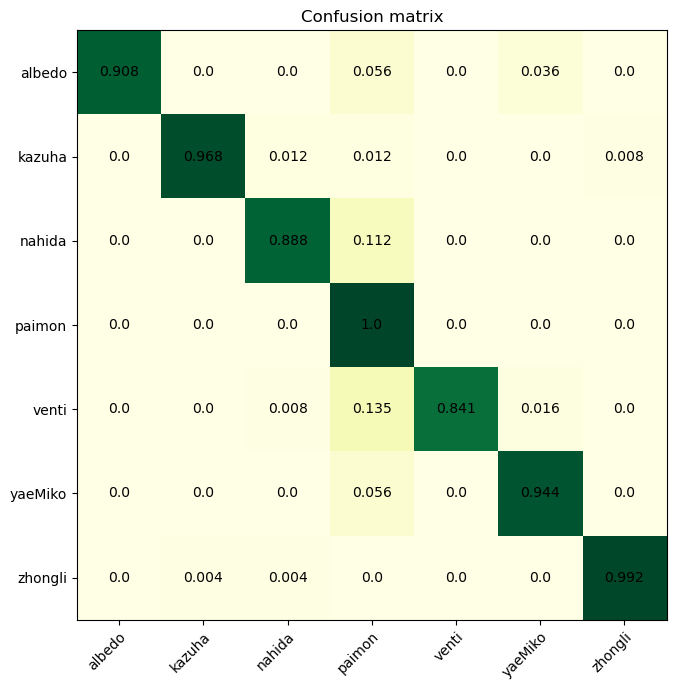

In [32]:
axis_label =   ["albedo",
                "kazuha",
                "nahida",
                "paimon",
                "venti",
                "yaeMiko",
                "zhongli"]

confmat = MulticlassConfusionMatrix(task="multiclass", num_classes=7, normalize='true')
confmat = confmat(torch.from_numpy(all_preds), torch.from_numpy(all_labels))
confmat.numpy()
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.imshow(confmat, cmap="YlGn")
ax.set_xticklabels(axis_label)
ax.set_yticklabels(axis_label)
ax.set_xticks(np.arange(len(axis_label)))
ax.set_yticks(np.arange(len(axis_label)))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(axis_label)):
    for j in range(len(axis_label)):
        text = ax.text(j, i, np.around(confmat[i, j].numpy(), decimals=3),
                       ha="center", va="center", color="#000000")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()